# xarray

xarray is
- a multi-dimensional version of pandas and
- built for working with netcdf files

Dask is an optional dependancy for xarray.  Using dask allows you to work in parallel with netcdf files that are bigger than memory.

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook

The equivalent of a pandas dataframe is an xarray dataset.  A dataset has:
- data variables e.g. an array of temperature data
- Coordinates that index the axes of the data variables
- dimension names for each axis.

The schematic shows how this would look where ```temperature``` and ```precipitation``` are data variables, ```lat``` and ```lon``` are 2D corrdinates while ```x```, ```y```, ```z``` and ```time``` are the dimension names.

[![a](https://github.com/pydata/xarray/raw/master/doc/_static/dataset-diagram.png)](https://github.com/pydata/xarray/raw/master/doc/_static/dataset-diagram.png)

Just as in pandas, the label names for the dimensions mean that we can use these labels directly when writing our analysis code.

Even better, using labels means that we don't have to remember the order of the dimensions in the underlying array. 

## Reading netcdf files
xarray is built to work with netcdf files.  This means that when xarray reads a netcdf file, it takes into account the metadata for each variable that show the variable name.

In [18]:
import xarray as xr
import numpy as np
import pandas as pd

np.random.seed(123)

times = pd.date_range('2000-01-01', '2001-12-31', name='time',freq='M')
annual_cycle = np.sin(2 * np.pi * (times.dayofyear.values / 365.25 - 0.28))

lon = np.arange(0,360)
lat = np.arange(-90,90)
Lon, Lat = np.meshgrid(lon, lat)
months = np.arange(24)
temp = 15 + 10*np.cos(2*np.pi*Lat/360)

temp = np.transpose( np.tile(temp,(len(months),1,1)), (1,2,0) )
for idx,mon in enumerate( times ):
    temp[:,:,idx] = temp[:,:,idx] -5*annual_cycle[idx]*np.sin(2*np.pi*Lat/360) + np.sin(2*np.pi*Lon/360)

ds = xr.Dataset({'temperature': (('lat', 'lon', 'time'), temp)},
                {'time': times, 'lon': lon, 'lat':lat})
ds.to_netcdf('global_temperature')

In [19]:
ds

<xarray.Dataset>
Dimensions:      (lat: 180, lon: 360, time: 24)
Coordinates:
  * time         (time) datetime64[ns] 2000-01-31 2000-02-29 2000-03-31 ...
  * lon          (lon) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * lat          (lat) int64 -90 -89 -88 -87 -86 -85 -84 -83 -82 -81 -80 -79 ...
Data variables:
    temperature  (lat, lon, time) float64 15.0 15.0 15.0 15.0 15.0 15.0 15.0 ...

## Loading data from a netcdf file

Data can be loaded from a single netcdf file using the ```open_dataset()``` method

In [20]:
ds = xr.open_dataset('global_temperature')

```ds``` is an xarray dataset. We can inspect it by typing ds

In [5]:
ds

<xarray.Dataset>
Dimensions:      (lat: 180, lon: 360, time: 24)
Coordinates:
  * lon          (lon) float64 0.0 1.003 2.006 3.008 4.011 5.014 6.017 7.019 ...
  * lat          (lat) float64 -90.0 -88.99 -87.99 -86.98 -85.98 -84.97 ...
  * time         (time) datetime64[ns] 2000-01-31 2000-02-29 2000-03-31 ...
Data variables:
    temperature  (lat, lon, time) float64 ...

The first line shows that names of the dimensions and their respective sizes.

The second block shows the coordinates. These are the 1D arrays that underlie the dimensions.  The coordinates cannot be modified.  If you want to modify a coordinate, you have to create a new coordinate. 

The third block shows the data variables - in this case just the temperature field.  We can see that the temperature has dimensions ```lat```,```lon``` and ```time```. The data variables can be modified e.g. converting kelvin to celsius.

## Labelled data
The variables and each of their dimensions now have labels attached.  This is great news!  

The first advantage of labelled data is that we can use these labels when analysing the outputs without needing to figure out which dimension is which.

For example, let's take the time-mean and plot it:

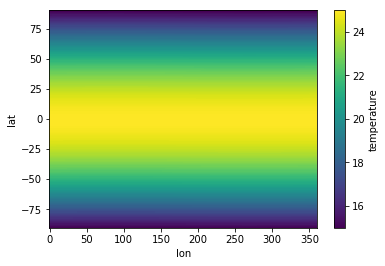

In [6]:
ds.temperature.mean(dim = 'time').plot()
plt.show()

Imagine coming back to this code months after you've written it - you'll know immediately what it does!

We could alternatively take the time and zonal mean by passing the dimension names as a list.

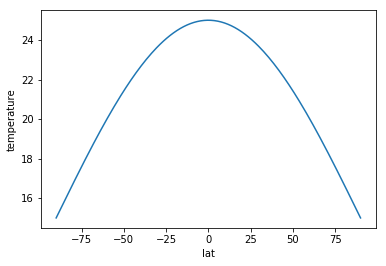

In [8]:
ds.temperature.mean(dim = ['time','lon']).plot()
plt.show()

The second advantage of labelled data is that xarray keeps track of the dimensions when we perform operations on the variables.  For example, this time we create a new variable in the dataset ```ds``` that holds the time-mean temperature.

In [9]:
ds['temp_mean'] = ds.temperature.mean(dim = 'time')
ds

<xarray.Dataset>
Dimensions:      (lat: 180, lon: 360, time: 24)
Coordinates:
  * lon          (lon) float64 0.0 1.003 2.006 3.008 4.011 5.014 6.017 7.019 ...
  * lat          (lat) float64 -90.0 -88.99 -87.99 -86.98 -85.98 -84.97 ...
  * time         (time) datetime64[ns] 2000-01-31 2000-02-29 2000-03-31 ...
Data variables:
    temperature  (lat, lon, time) float64 15.0 15.0 15.0 15.0 15.0 15.0 15.0 ...
    temp_mean    (lat, lon) float64 15.0 15.0 15.0 15.0 15.0 15.0 15.0 15.0 ...

Xarray has seen that you've taken the time mean and reduced the dimension of ```temp_mean``` accordingly so ```temp_mean``` only - you don't have to worry about singleton dimensions hanging around.

Even better, xarray will take care of the details when you do operations between variables with dimensions that aren't identical

In [10]:
ds['temp_anomalies'] = ds.temperature - ds.temp_mean
ds

<xarray.Dataset>
Dimensions:         (lat: 180, lon: 360, time: 24)
Coordinates:
  * lon             (lon) float64 0.0 1.003 2.006 3.008 4.011 5.014 6.017 ...
  * lat             (lat) float64 -90.0 -88.99 -87.99 -86.98 -85.98 -84.97 ...
  * time            (time) datetime64[ns] 2000-01-31 2000-02-29 2000-03-31 ...
Data variables:
    temperature     (lat, lon, time) float64 15.0 15.0 15.0 15.0 15.0 15.0 ...
    temp_mean       (lat, lon) float64 15.0 15.0 15.0 15.0 15.0 15.0 15.0 ...
    temp_anomalies  (lat, lon, time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...

In this case xarray handled the broadcasting needed to add the ```time``` dimension back on to the ```temp_mean``` variable.

## Indexing data

Indexing in xarray follows concepts from pandas. In pandas you use ```.loc``` to select data using the explicit index and ```.iloc``` to select data using the *implicit* index (i.e. an integer count of the rows).

In xarray you use ```.sel``` to select data using the explicit coordinate index and ```.isel``` to select data using the *implicit* coordinate index (i.e. an integer count of the position along the index).

This is easier to understand with examples.  Firstly, we look at the temperature along through time where lat = 59 and lon = 18.

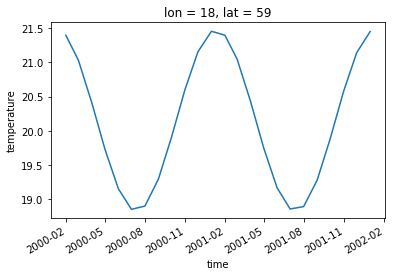

In [29]:
ds.temperature.sel(lat = 59,lon = 18).plot()
plt.show()

The actual coordinate values are often long decimal numbers rather than integers. In this case we can give integers and specify a method for finding the nearest location, in this case 'nearest'

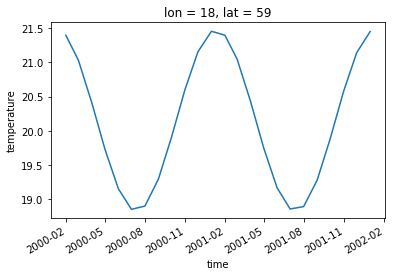

In [31]:
ds.temperature.sel(lat = 59.3, lon = 18.2, method='nearest').plot()
plt.show()

We can also use the ```.isel``` method for selecting data if we know the position we want rather than its value.  For example, to plot the third month in the dataset:

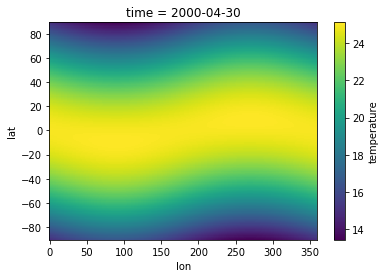

In [32]:
ds.temperature.isel(time = 3).plot()
plt.show()

# Groupby in xarray

Xarray also has some powerful groupby methods.  For example, if we want to calculate the seasonal cycle:

In [35]:
season_cycle = ds.temperature.groupby('time.month').mean(dim = 'time')
season_cycle

<xarray.DataArray 'temperature' (lat: 180, lon: 360, month: 12)>
array([[[ 15.      ,  15.      , ...,  15.      ,  15.      ],
        [ 14.917873,  14.941437, ...,  14.934253,  14.914217],
        ..., 
        [ 15.164228,  15.117108, ...,  15.131474,  15.171539],
        [ 15.082127,  15.058563, ...,  15.065747,  15.085783]],

       [[ 15.174524,  15.174524, ...,  15.174524,  15.174524],
        [ 15.09241 ,  15.11597 , ...,  15.108787,  15.088754],
        ..., 
        [ 15.338727,  15.291614, ...,  15.305978,  15.346037],
        [ 15.256638,  15.233078, ...,  15.240261,  15.260294]],

       ..., 
       [[ 15.348995,  15.348995, ...,  15.348995,  15.348995],
        [ 15.431072,  15.407522, ...,  15.414702,  15.434725],
        ..., 
        [ 15.184867,  15.231958, ...,  15.217601,  15.17756 ],
        [ 15.266918,  15.290468, ...,  15.283288,  15.263264]],

       [[ 15.174524,  15.174524, ...,  15.174524,  15.174524],
        [ 15.256638,  15.233078, ...,  15.240261,  15.2

This groupby operation has created a new data array where the coordinates are lat, lon and month i.e. the average temperature for each month at each grid point.

Even better, we can now create a new variable in ```ds``` that has the seasonal cycle removed.
We do this by using ```.groupby``` on ```ds.temperature``` to partition

In [38]:
ds['temp_deseason'] = ds.temperature.groupby('time.month') - season_cycle
ds

<xarray.Dataset>
Dimensions:        (lat: 180, lon: 360, time: 24)
Coordinates:
  * lon            (lon) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * lat            (lat) int32 -90 -89 -88 -87 -86 -85 -84 -83 -82 -81 -80 ...
  * time           (time) datetime64[ns] 2000-01-31 2000-02-29 2000-03-31 ...
    month          (time) int64 1 2 3 4 5 6 7 8 9 10 11 12 1 2 3 4 5 6 7 8 9 ...
Data variables:
    temperature    (lat, lon, time) float64 ...
    temp_deseason  (lat, lon, time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...

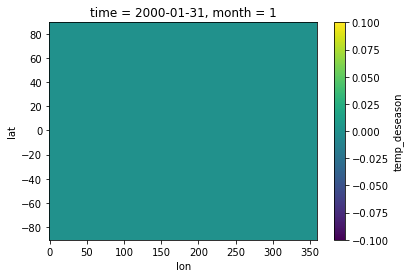

In [39]:
ds.temp_deseason.isel(time = 0).plot()
plt.show()